In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1) Chargement des données et préprocessing

In [2]:
def resampling(data,len_min):
    
    ratio = int(len(data)/len_min)
    new_df = pd.DataFrame(index = range(len_min))
    resampled_list = []
    
    for window in range(len_min):
        resampled_list.extend([window]*ratio)
    
    data['sampled'] = resampled_list
    new_df = data.groupby('sampled').agg(["mean"],axis = "columns")
    new_df.columns= data.columns.drop('sampled')
            
    return(new_df)

In [3]:
resample_data = pd.DataFrame()

for subject in range(1,16):
    #Ouvre les fichiers
    num_patient = f"S{subject}"
    path = f"./PPG_FieldStudy/{num_patient}/{num_patient}.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin-1")
        
    #Extrait les données de "Wrist"
    wrist_ACC_data = pd.DataFrame(data["signal"]['wrist']['ACC'],columns=['wrist_ACC_X', 'wrist_ACC_Y', 'wrist_ACC_Z'])
    
    #Re-échantillone les donées de "Wrist" par rapport à la valeure minimale que l'on a : "EDA"
    
    resampled_size = len(data["signal"]['wrist']['EDA'])
    resample_wrist_ACC_data = resampling(wrist_ACC_data,resampled_size)
    
    wrist_BVP_data = pd.DataFrame(data["signal"]['wrist']['BVP'],columns = ['BVP'])
    resample_wrist_BVP_data = resampling(wrist_BVP_data,resampled_size)
    resample_wrist_data = pd.concat([resample_wrist_BVP_data, resample_wrist_ACC_data,pd.DataFrame(data["signal"]['wrist']['EDA'],columns = ['EDA'])],axis=1)
    
    #Extrait les données de "chest"
    chest_data = pd.DataFrame(index=range(len(data["signal"]['chest']["ACC"])))
    dico = data["signal"]['chest']
    for key in dico:
        if key != "ACC":
            chest_data[f'chest_{key}'] = pd.DataFrame(dico[key])
        else:
            chest_data = pd.concat([chest_data, pd.DataFrame(data["signal"]['chest']['ACC'], columns = ['chest_ACC_X', 'chest_ACC_Y', 'chest_ACC_Z'])],axis = 1)
    
    #Ajoute les rpeaks
    list_rpeaks = [0]*len(chest_data)
    for index in data['rpeaks']:
        list_rpeaks[index] = 1
    chest_data['rpeaks'] = list_rpeaks
    
    #Re-échantillone les donées de "chest" par rapport à la valeure minimale que l'on a : "EDA"
    resample_chest_data = resampling(chest_data,resampled_size)
    
    resample_subject_data=pd.concat([resample_wrist_data,resample_chest_data,pd.DataFrame(data['activity'],columns=['activity'])],axis=1)
    
    #Ajoute les questionnaires
    for key in data['questionnaire']:
        resample_subject_data[key] = data['questionnaire'][key]
    
    resample_data = pd.concat([resample_data,resample_subject_data], axis = 0)
    
resample_data = pd.concat([resample_data, pd.get_dummies(resample_data['Gender'])],axis = 1)
resample_data.drop(columns = ['Gender'], inplace = True) 

resample_data.head()

,BVP,wrist_ACC_X,wrist_ACC_Y,wrist_ACC_Z,EDA,chest_ACC_X,chest_ACC_Y,chest_ACC_Z,chest_ECG,chest_EMG,...,chest_Resp,rpeaks,activity,WEIGHT,AGE,HEIGHT,SKIN,SPORT,f,m
0,0.138125,-0.763672,-0.076172,0.669922,4.722437,0.852157,-0.066488,-0.367784,0.035650,-1.5,...,4.834438,0.000000,0.0,78.0,34,182.0,3,6,0,1
1,-26.262500,-0.763672,-0.078125,0.671875,4.728843,0.851262,-0.066655,-0.370442,0.103145,-1.5,...,4.238839,0.005714,0.0,78.0,34,182.0,3,6,0,1
2,-40.959375,-0.761719,-0.078125,0.671875,4.718594,0.851570,-0.064677,-0.370251,0.099101,-1.5,...,2.058559,0.000000,0.0,78.0,34,182.0,3,6,0,1
3,24.173125,-0.753906,-0.078125,0.671875,4.717312,0.852142,-0.065486,-0.371278,-0.170757,-1.5,...,-0.463981,0.000000,0.0,78.0,34,182.0,3,6,0,1
4,25.781250,-0.761719,-0.076172,0.671875,4.713469,0.851958,-0.065894,-0.370466,-0.036633,-1.5,...,-1.867397,0.000000,0.0,78.0,34,182.0,3,6,0,1


# 2) Analyse des données

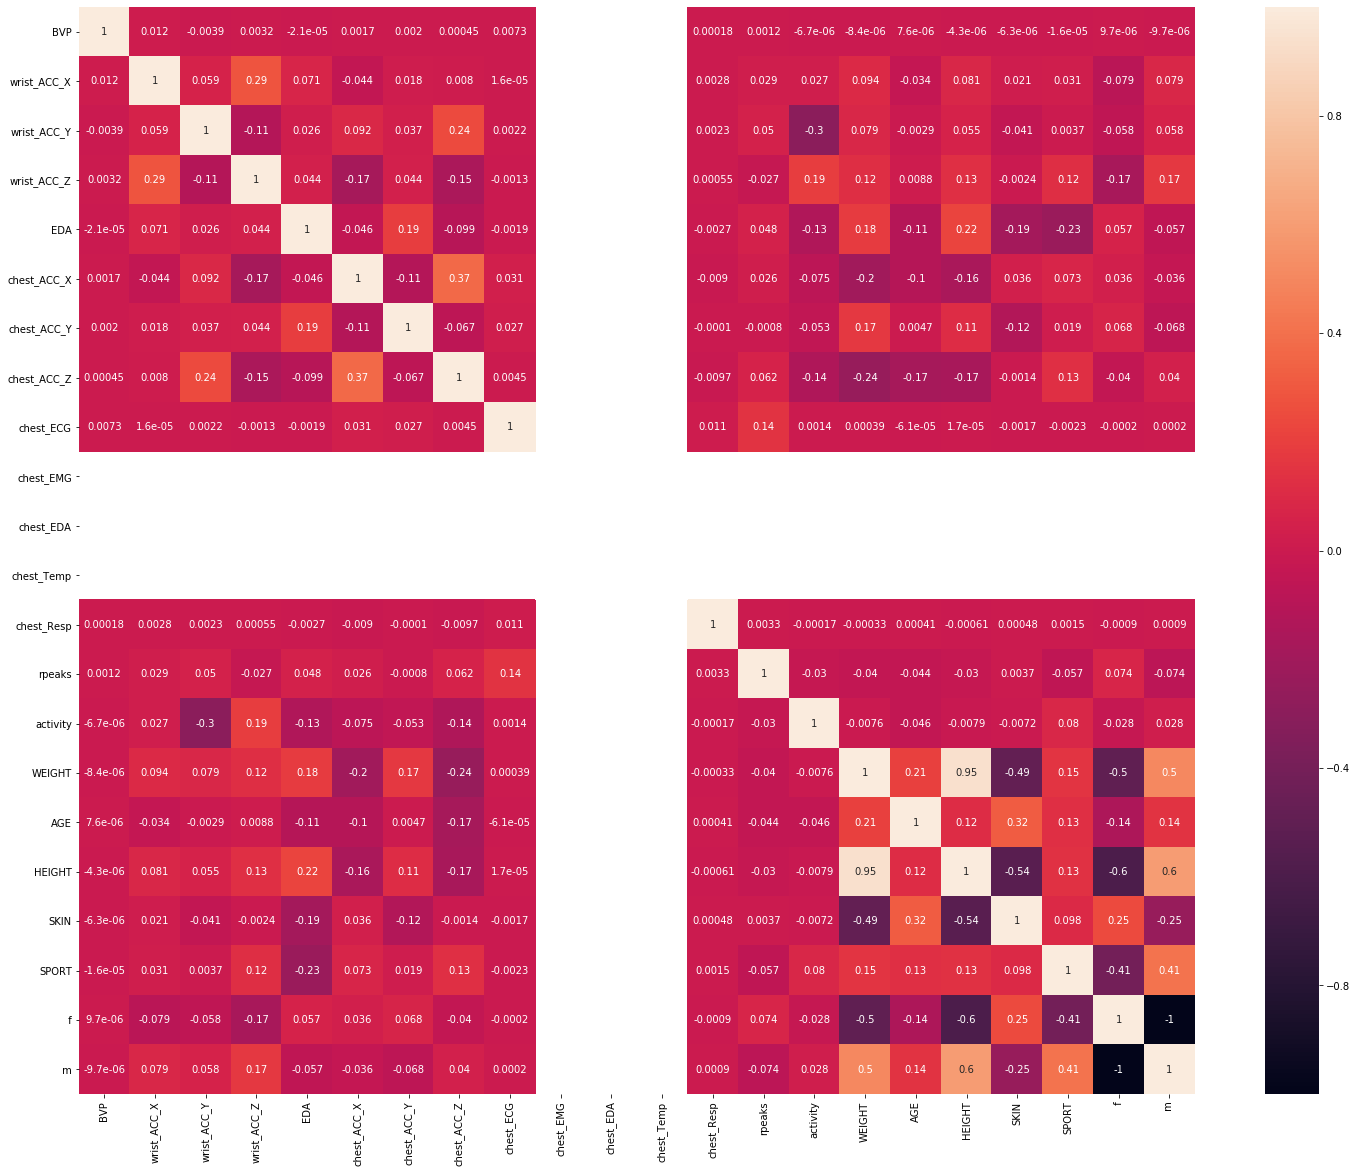

In [4]:
correlation = resample_data.corr()
f, ax = plt.subplots(figsize = (25, 20))
sns.heatmap(correlation, annot = True)

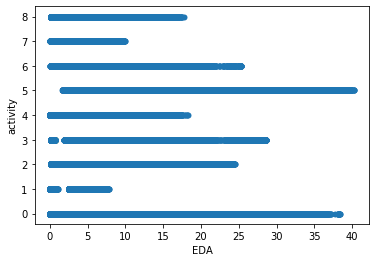

In [5]:
sns.scatterplot(x = "EDA",y = "activity",data = resample_data,linewidth = 0)

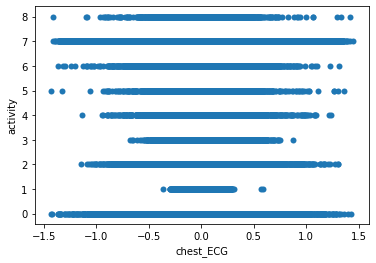

In [24]:
sns.scatterplot(x = "chest_ECG",y = "activity",data = resample_data,linewidth = 0)

# 3) Création du jeu de test et du jeu d'entraînement

In [6]:
train, test = train_test_split(resample_data, test_size=0.2)

x_train = train.drop(columns=['activity'])
y_train = train['activity']

x_test = test.drop(columns=['activity'])
y_test = test['activity']

# 4) Création des modèles

## 4.1) Random Forest

In [7]:
RF_clf = RandomForestClassifier(n_estimators = 10)
RF_clf.fit(x_train, y_train)

y_pred = RF_clf.predict(x_test)

In [8]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     28211
         1.0       0.99      0.99      0.99      7211
         2.0       0.89      0.79      0.84      5165
         3.0       0.94      0.87      0.90      3778
         4.0       0.97      0.97      0.97      5654
         5.0       0.97      0.98      0.98     10894
         6.0       0.96      0.94      0.95     21649
         7.0       0.85      0.76      0.80      7466
         8.0       0.99      0.96      0.97     13564

    accuracy                           0.92    103592
   macro avg       0.93      0.91      0.92    103592
weighted avg       0.93      0.92      0.92    103592



## 4.2) Gradient Boosting

In [9]:
GBC = GradientBoostingClassifier()
GBC.fit(x_train,y_train)

y_pred_gbc = GBC.predict(x_test)

In [10]:
print(metrics.classification_report(y_test,y_pred_gbc))

              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71     28211
         1.0       0.90      0.97      0.93      7211
         2.0       0.77      0.58      0.66      5165
         3.0       0.80      0.70      0.74      3778
         4.0       0.90      0.94      0.92      5654
         5.0       0.90      0.92      0.91     10894
         6.0       0.80      0.86      0.83     21649
         7.0       0.68      0.46      0.55      7466
         8.0       0.88      0.85      0.87     13564

    accuracy                           0.80    103592
   macro avg       0.81      0.78      0.79    103592
weighted avg       0.79      0.80      0.79    103592



## 4.3) KNeighbors

In [11]:
KNC = KNeighborsClassifier(n_neighbors = 3)
KNC.fit(x_train,y_train)
y_pred_KNC = KNC.predict(x_test)

In [12]:
print(metrics.classification_report(y_test,y_pred_KNC))

              precision    recall  f1-score   support

         0.0       0.52      0.65      0.58     28211
         1.0       0.70      0.77      0.74      7211
         2.0       0.48      0.42      0.45      5165
         3.0       0.44      0.34      0.38      3778
         4.0       0.57      0.48      0.52      5654
         5.0       0.72      0.70      0.71     10894
         6.0       0.67      0.64      0.66     21649
         7.0       0.50      0.33      0.40      7466
         8.0       0.68      0.62      0.65     13564

    accuracy                           0.60    103592
   macro avg       0.59      0.55      0.56    103592
weighted avg       0.60      0.60      0.60    103592



## 4.4) Comparaison des modèles

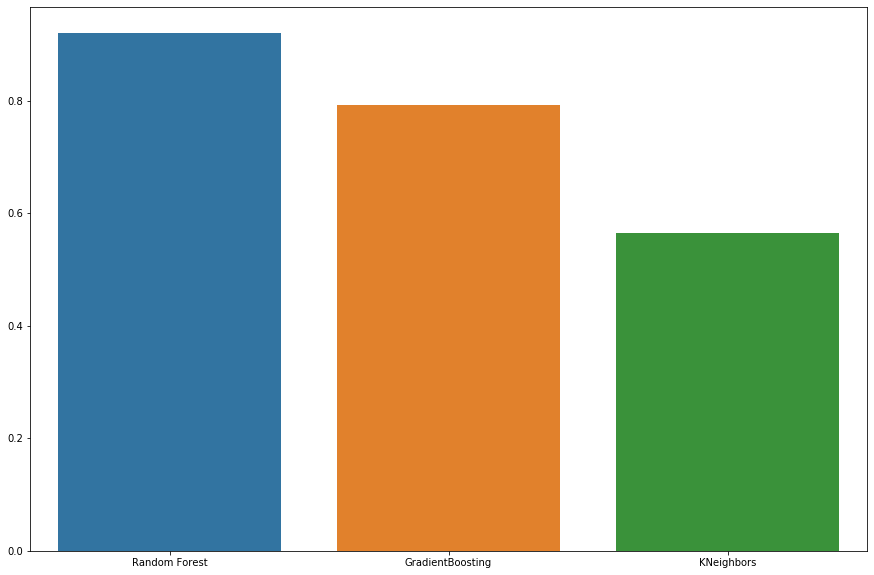

In [19]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(['Random Forest', 'GradientBoosting', 'KNeighbors'], 
            [metrics.f1_score(y_test,y_pred,average='macro'),metrics.f1_score(y_test,y_pred_gbc,average='macro'),
             metrics.f1_score(y_test,y_pred_KNC,average='macro')])

# 5) Grille de recherche

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Nombre d'abres dans le random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]

# Nombre de fonctionnalités à considérer à chaque divison
max_features = ['auto', 'sqrt']

# Nombre maximum de niveaux dans l'arborescence
max_depth = [int(x) for x in np.linspace(10, 100, num = 3 )]
max_depth.append(None)

# Nombre minimal d'échantillons requis pour diviser un nœud
min_samples_split = [2, 5, 7]

# Nombre minimal d'échantillons requis à chaque feuille d'un noeud
min_samples_leaf = [1, 2, 4]

# Méthode de sélection des échantillons pour la formation de chaque arbre
bootstrap = [True, False]# Creation d'une grille aléatoire
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

RandomForest_GridSearch_Clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = RandomForest_GridSearch_Clf, param_distributions = random_grid, n_iter = 20 , cv = 3, verbose=2, random_state=42, n_jobs = -1)# Adapte le modèle de recherche aléatoire
rf_random.fit(x_train, y_train)

{'n_estimators': [20, 65, 110, 155, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 55, 100, None], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 24.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [15]:
rf_random.best_params_  #Affiche les meilleures parametres de la grille de recherche

{'n_estimators': 155,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 55,
 'bootstrap': False}

## 5.1) Random Forest avec parametres optimisés

In [17]:
optimized_RF_clf = RandomForestClassifier(n_estimators = 155, min_samples_split = 2, min_samples_leaf = 1, 
                                          max_features = "auto", max_depth = 55, bootstrap = False)
optimized_RF_clf.fit(x_train, y_train)

optimized_y_pred = optimized_RF_clf.predict(x_test)

In [18]:
print(metrics.classification_report(y_test,optimized_y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     28211
         1.0       0.99      0.99      0.99      7211
         2.0       0.93      0.85      0.89      5165
         3.0       0.95      0.90      0.93      3778
         4.0       0.98      0.98      0.98      5654
         5.0       0.98      0.99      0.98     10894
         6.0       0.97      0.95      0.96     21649
         7.0       0.88      0.83      0.86      7466
         8.0       0.99      0.97      0.98     13564

    accuracy                           0.95    103592
   macro avg       0.95      0.94      0.94    103592
weighted avg       0.95      0.95      0.95    103592



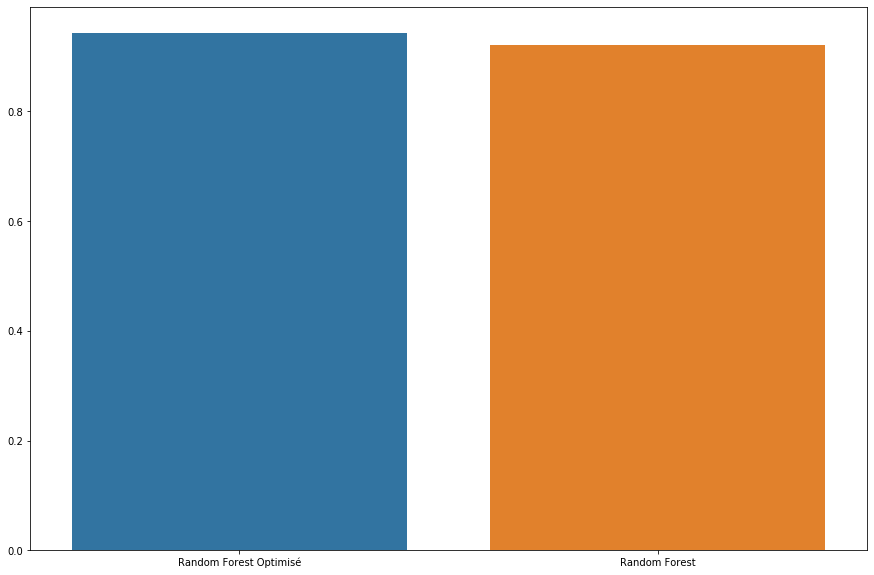

In [20]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(['Random Forest Optimisé', 'Random Forest'], [metrics.f1_score(y_test,optimized_y_pred,average='macro'),
                                                          metrics.f1_score(y_test,y_pred,average='macro')])

## 5.2) Features importantes

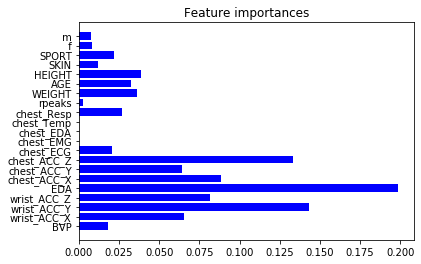

In [26]:
plt.figure()
plt.title("Feature importances")
plt.barh(x_train.columns, optimized_RF_clf.feature_importances_,color="b", align="center")
plt.show()

# 6) Export du modèle

In [21]:
filename = 'ppgdalia/prediction/RF_clf.pkl'
pickle.dump(optimized_RF_clf, open(filename, 'wb'))